In [1]:
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import seaborn as sns
import random

def configure_model(model):
    model.Params.OutputFlag = 0
    model.Params.TimeLimit = 100
    model.Params.MIPGap = 0.05
    model.Params.Presolve = 2
    model.Params.MIPFocus = 1
    model.Params.Heuristics = 0.8
    model.Params.Threads = 8

In [2]:
# Parameters
m = 8
K = 5
L_levels = [25, 20, 15, 12, 10]
E_levels = [13, 28, 38, 45, 120] 
E_PU_max = [8000] * m 
CPU_capacity = [3000] * m
f_v_levels = [30, 40, 60, 80, 100]
P_idle = [16] * m
P_max = [40] * m
T_total = 300
total_tasks = 150
from collections import Counter

# Task chain definitions
chain_tasks = {
    0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    2: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    3: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    4: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
    5: [50, 51, 52, 53, 54, 55, 56, 57],
    6: [58, 59, 60],
    7: [61, 62, 63],
    8: [64, 65, 66],
    9: [67, 68, 69],
    10: [70, 71, 72],
    11: [73, 74, 75],
    12: [76, 77, 78],
    13: [79, 80, 81],
    14: [82, 83, 84],
    15: [85, 86, 87],
    16: [88, 89, 90],
    17: [91, 92, 93],
    18: [94, 95, 96],
    19: [97, 98, 99]
}

num_chains = len(chain_tasks)
n = max(max(v) for v in chain_tasks.values()) + 1  # Total number of tasks
buffer = 0.2  
L_max = [int(len(chain_tasks[k]) * min(L_levels) * (1 + buffer)) for k in chain_tasks]



def run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=None):
    model = gp.Model("MAF_Optimization")
    configure_model(model)
    if E_PU_max is None:
        E_PU_max = [8000] * m  

    
    delta = model.addVars(n, vtype=GRB.BINARY, name="delta")
    w = model.addVars(n, m, vtype=GRB.BINARY, name="w")
    y = model.addVars(n, K, vtype=GRB.BINARY, name="y")
    z = model.addVars(num_chains, vtype=GRB.BINARY, name="z")
    E_PU = model.addVars(m, name="E_PU")

    if baseline:
        for i in range(n):
            model.addConstr(y[i, K - 1] == delta[i])
            for k in range(K - 1):
                model.addConstr(y[i, k] == 0)

    for i in range(n):
        model.addConstr(gp.quicksum(w[i, j] for j in range(m)) == delta[i])
        model.addConstr(gp.quicksum(y[i, k] for k in range(K)) == delta[i])
        for k in range(K):
            model.addConstr(y[i, k] <= delta[i])  # Ensure y[i,k]=0 if task is inactive

    for k in range(num_chains):
        model.addConstr(gp.quicksum(delta[i] for i in chain_tasks[k]) == z[k] * len(chain_tasks[k]))
        delay_chain = gp.quicksum(y[i, k_] * L_levels[k_] for i in chain_tasks[k] for k_ in range(K))
        model.addConstr(delay_chain <= L_max[k])

    for j in range(m):
        model.addConstr(
            gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * f_v_levels[k] for k in range(K)) for i in range(n)) <= CPU_capacity[j]
        )
        active_time = gp.quicksum(w[i, j] * gp.quicksum(y[i, k] * L_levels[k] for k in range(K)) for i in range(n))
        U_j = active_time / T_total
        E_PU_expr = P_idle[j] * (T_total - active_time) + (P_max[j] - P_idle[j]) * U_j * T_total
        model.addConstr(E_PU[j] == E_PU_expr)
        model.addConstr(E_PU[j] <= E_PU_max[j])

    total_task_energy = gp.quicksum(y[i, k] * E_levels[k] for i in range(n) for k in range(K))
    total_chain_accept = gp.quicksum(z[k] for k in range(num_chains))
    total_pu_energy = gp.quicksum(E_PU[j] for j in range(m))

    model.setObjective(
        alpha_1 * total_chain_accept - alpha_2 * total_task_energy - alpha_3 * total_pu_energy,
        GRB.MAXIMIZE
    )


    model.write("model_before_optimize.lp") 
    start_time = time.time()
    model.optimize()
    end_time = time.time()
    model.write("model_after_optimize.lp")   


    if model.status == GRB.INFEASIBLE:
        print("🚫 Infeasible model! Computing IIS...")
        model.computeIIS()
        model.write("model_infeasible.ilp")
        print("\n🚨 Infeasible Constraints in IIS:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(f" - {c.constrName}")
        return None

    if model.status != GRB.OPTIMAL:
        print("❌ Model optimization failed (status =", model.status, ").")
        return None


    print(f"⏱️ Gurobi Runtime: {end_time - start_time:.2f} seconds")
    print("\n📋 Chain Activation Overview:")
    for k in range(num_chains):
        status = "✅ Activated" if z[k].X > 0.5 else "❌ Not activated"
        task_list = chain_tasks[k]
        print(f"Chain {k}: {status}, Tasks: {task_list}")

    accepted_chains = [k for k in range(num_chains) if z[k].X > 0.5]
    pu_assignment = [j for i in range(n) for j in range(m) if w[i, j].X > 0.5]
    pu_task_map = {}
    for task_id, pu_id in enumerate(pu_assignment):
        pu_task_map.setdefault(pu_id, []).append(task_id)

    task_energy_levels = [max((y[i, k].X, k) for k in range(K))[1] if delta[i].X > 0.5 else -1 for i in range(n)]
    

    return {
        "Mode": "Baseline" if baseline else "Non-Baseline",
        "Objective Value": model.ObjVal,
        "Accepted Chains": len(accepted_chains),
        "Total PU Energy": sum(E_PU[j].X for j in range(m)),
        "Total Task Energy": sum(y[i, k].X * E_levels[k] for i in range(n) for k in range(K)),
        "Runtime": model.Runtime,
        "PU Task Assignment": pu_task_map,
        "Task Energy Levels": task_energy_levels,
        "Activated Chain List": [1 if z[k].X > 0.5 else 0 for k in range(num_chains)],
        "Total Chains": num_chains 
    }

In [3]:
def visualize_baseline_vs_optimal_extended(baseline, optimal):
    def add_text(ax, x_pos, height, text, threshold=0, offset=5, y_max_ratio=0.95):
        if height > threshold:
            y_max = ax.get_ylim()[1]
            safe_y = min(height + offset, y_max * y_max_ratio)
            ax.text(x_pos, safe_y, str(text), ha='center', fontsize=10)

    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Baseline vs Optimal Comparison Summary", fontsize=16, y=1.02)

    # 1. Execution Time
    axs[0, 0].bar(['Baseline', 'Optimal'], [baseline['Runtime'], optimal['Runtime']], color=['skyblue', 'orange'])
    axs[0, 0].set_title("Execution Time (s)")
    axs[0, 0].set_ylabel("Time (s)")
    for i, val in enumerate([baseline['Runtime'], optimal['Runtime']]):
        add_text(axs[0, 0], i, val, f"{val:.2f}", offset=0.03)

    # 2. Chain Acceptance Rate
    baseline_accept = baseline['Accepted Chains'] / baseline['Total Chains']
    optimal_accept = optimal['Accepted Chains'] / optimal['Total Chains']
    axs[0, 1].bar(['Baseline', 'Optimal'], [baseline_accept, optimal_accept], color=['skyblue', 'orange'])
    axs[0, 1].set_title("Chain Acceptance Rate")
    axs[0, 1].set_ylabel("Ratio")
    for i, val in enumerate([baseline_accept, optimal_accept]):
        add_text(axs[0, 1], i, val, f"{val * 100:.1f}%", offset=0.03)

    # 3. Total Energy
    baseline_energy = baseline['Total PU Energy'] + baseline['Total Task Energy']
    optimal_energy = optimal['Total PU Energy'] + optimal['Total Task Energy']
    axs[0, 2].bar(['Baseline', 'Optimal'], [baseline_energy, optimal_energy], color=['skyblue', 'orange'])
    axs[0, 2].set_title("Total Energy Consumption")
    axs[0, 2].set_ylabel("Energy")
    for i, val in enumerate([baseline_energy, optimal_energy]):
        add_text(axs[0, 2], i, val, f"{val:.1f}", offset=3000)

    # 4. Energy Saving %
    saving_percent = (baseline_energy - optimal_energy) / baseline_energy * 100
    axs[1, 0].bar(['Baseline', 'Optimal'], [0, saving_percent], color=['skyblue', 'orange'])
    axs[1, 0].set_title("Energy Saving Compared to Baseline (%)")
    axs[1, 0].set_ylabel("Saving (%)")
    add_text(axs[1, 0], 1, saving_percent, f"{saving_percent:.2f}%", offset=0.5)

    # 5. Task Count per PU
    pu_task_count_baseline = [len(baseline['PU Task Assignment'].get(j, [])) for j in range(m)]
    pu_task_count_optimal = [len(optimal['PU Task Assignment'].get(j, [])) for j in range(m)]
    x = np.arange(m)
    axs[1, 1].bar(x - 0.2, pu_task_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 1].bar(x + 0.2, pu_task_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 1].set_title("Task Count per PU")
    axs[1, 1].set_xlabel("PU Index")
    axs[1, 1].set_ylabel("Task Count")
    axs[1, 1].legend()
    for i in x:
        add_text(axs[1, 1], i - 0.2, pu_task_count_baseline[i], pu_task_count_baseline[i])
        add_text(axs[1, 1], i + 0.2, pu_task_count_optimal[i], pu_task_count_optimal[i])

    # 6. Task Count per Energy Level
    energy_count_baseline = [baseline['Task Energy Levels'].count(k) for k in range(K)]
    energy_count_optimal = [optimal['Task Energy Levels'].count(k) for k in range(K)]
    x2 = np.arange(K)
    axs[1, 2].bar(x2 - 0.2, energy_count_baseline, width=0.4, label='Baseline', color='skyblue')
    axs[1, 2].bar(x2 + 0.2, energy_count_optimal, width=0.4, label='Optimal', color='orange')
    axs[1, 2].set_title("Task Count per Energy Level")
    axs[1, 2].set_xlabel("Energy Level")
    axs[1, 2].set_ylabel("Task Count")
    axs[1, 2].set_xticks(x2)
    axs[1, 2].set_xticklabels([f"Level {i+1}" for i in range(K)])
    axs[1, 2].legend()
    for i in x2:
        add_text(axs[1, 2], i - 0.2, energy_count_baseline[i], energy_count_baseline[i])
        add_text(axs[1, 2], i + 0.2, energy_count_optimal[i], energy_count_optimal[i])

    # 7. Objective Function Value
    axs[2, 0].bar(['Baseline', 'Optimal'], [baseline['Objective Value'], optimal['Objective Value']], color=['skyblue', 'orange'])
    axs[2, 0].set_title("Objective Function Value")
    axs[2, 0].set_ylabel("Value")
    for i, val in enumerate([baseline['Objective Value'], optimal['Objective Value']]):
        add_text(axs[2, 0], i, val, f"{val:.2f}", offset=3000)

    axs[2, 1].axis('off')
    axs[2, 2].axis('off')

    plt.tight_layout()
    plt.show()


def run_multi_E_PU_max_experiments(alpha_1, alpha_2, alpha_3, E_PU_max_list):
    results = []

    for limit in E_PU_max_list:
        print(f"Testing E_PU_max = {limit}")

        baseline_result = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=True, E_PU_max=[limit] * m)
        optimal_result  = run_gurobi_model(alpha_1, alpha_2, alpha_3, baseline=False, E_PU_max=[limit] * m)

        results.append({
            "E_PU_max": limit,
            "baseline": baseline_result,
            "optimal": optimal_result
        })

    return results

def run_and_plot_all(alpha_1, alpha_2, alpha_3, E_PU_max_list):

    print(" Running multi E_PU_max experiment...")

    results = run_multi_E_PU_max_experiments(
        alpha_1=alpha_1,
        alpha_2=alpha_2,
        alpha_3=alpha_3,
        E_PU_max_list=E_PU_max_list
    )

    print(" Plotting full summary chart...")
    plot_all_metrics_summary(results, E_PU_max_list)

    return results



def plot_all_metrics_summary(results, E_PU_max_list):
    x = np.arange(len(E_PU_max_list))
    width = 0.35

    def add_labels(ax, x_vals, heights, offset=0.02, format_str="{:.2f}"):
        if not heights: return
        for x0, h in zip(x_vals, heights):
            if h > 0:
                ax.text(x0, h + offset * max(heights), format_str.format(h), ha='center', fontsize=9)

    # Extract metrics
    baseline_time = [r["baseline"]["Runtime"] if r["baseline"] else 0 for r in results]
    optimal_time = [r["optimal"]["Runtime"] if r["optimal"] else 0 for r in results]

    baseline_accept = [r["baseline"]["Accepted Chains"] / r["baseline"]["Total Chains"] * 100 if r["baseline"] else 0 for r in results]
    optimal_accept = [r["optimal"]["Accepted Chains"] / r["optimal"]["Total Chains"] * 100 if r["optimal"] else 0 for r in results]

    energy_saving = []
    for r in results:
        if r["baseline"] and r["optimal"]:
            b_energy = r["baseline"]["Total PU Energy"] + r["baseline"]["Total Task Energy"]
            o_energy = r["optimal"]["Total PU Energy"] + r["optimal"]["Total Task Energy"]
            saving = (b_energy - o_energy) / b_energy * 100
            energy_saving.append(saving)
        else:
            energy_saving.append(0)

    baseline_energy = [
        r["baseline"]["Total PU Energy"] + r["baseline"]["Total Task Energy"] if r["baseline"] else 0
        for r in results
    ]
    optimal_energy = [
        r["optimal"]["Total PU Energy"] + r["optimal"]["Total Task Energy"] if r["optimal"] else 0
        for r in results
    ]

    baseline_objective = [r["baseline"]["Objective Value"] if r["baseline"] else 0 for r in results]
    optimal_objective = [r["optimal"]["Objective Value"] if r["optimal"] else 0 for r in results]

    # Plot layout
    fig, axs = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle("📊 Full Metrics Comparison of Baseline vs Optimal", fontsize=18)

    # 1. Execution Time
    ax = axs[0, 0]
    ax.bar(x - width/2, baseline_time, width, label='Baseline', color='skyblue')
    ax.bar(x + width/2, optimal_time, width, label='Optimal', color='orange')
    ax.set_title("Execution Time (s)")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Time (s)")
    add_labels(ax, x - width/2, baseline_time)
    add_labels(ax, x + width/2, optimal_time)
    ax.legend()

    # 2. Acceptance Rate (%)
    ax = axs[0, 1]
    ax.bar(x - width/2, baseline_accept, width, label='Baseline', color='skyblue')
    ax.bar(x + width/2, optimal_accept, width, label='Optimal', color='orange')
    ax.set_title("Acceptance Rate (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Acceptance (%)")
    add_labels(ax, x - width/2, baseline_accept, format_str="{:.1f}")
    add_labels(ax, x + width/2, optimal_accept, format_str="{:.1f}")
    ax.legend()

    # 3. Energy Saving (%)
    ax = axs[1, 0]
    ax.bar(x, energy_saving, width=0.6, color='green')
    ax.set_title("Energy Saving Compared to Baseline (%)")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Saving (%)")
    add_labels(ax, x, energy_saving, format_str="{:.2f}")

    # 4. Total Energy
    ax = axs[1, 1]
    ax.bar(x - width/2, baseline_energy, width, label='Baseline', color='skyblue')
    ax.bar(x + width/2, optimal_energy, width, label='Optimal', color='orange')
    ax.set_title("Total Energy Consumption")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Energy")
    add_labels(ax, x - width/2, baseline_energy)
    add_labels(ax, x + width/2, optimal_energy)
    ax.legend()

    # 5. Objective Function
    ax = axs[2, 0]
    ax.bar(x - width/2, baseline_objective, width, label='Baseline', color='skyblue')
    ax.bar(x + width/2, optimal_objective, width, label='Optimal', color='orange')
    ax.set_title("Objective Function Value")
    ax.set_xticks(x)
    ax.set_xticklabels(E_PU_max_list)
    ax.set_ylabel("Objective")
    add_labels(ax, x - width/2, baseline_objective)
    add_labels(ax, x + width/2, optimal_objective)
    ax.legend()

    axs[2, 1].axis('off')

    plt.tight_layout()
    plt.show()



In [ ]:
results = run_and_plot_all(alpha_1=8000.0, alpha_2=3.0, alpha_3=1.0, E_PU_max_list=[6000, 5700, 5500, 5400])


 Running multi E_PU_max experiment...
Testing E_PU_max = 6000
Set parameter Username
Set parameter LicenseID to value 2597751
Academic license - for non-commercial use only - expires 2025-12-10
⏱️ Gurobi Runtime: 0.05 seconds

📋 Chain Activation Overview:
Chain 0: ✅ Activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ✅ Activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ✅ Activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ✅ Activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ✅ Activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ✅ Activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Ch

⏱️ Gurobi Runtime: 0.05 seconds

📋 Chain Activation Overview:
Chain 0: ✅ Activated, Tasks: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Chain 1: ✅ Activated, Tasks: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Chain 2: ✅ Activated, Tasks: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Chain 3: ✅ Activated, Tasks: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Chain 4: ✅ Activated, Tasks: [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Chain 5: ✅ Activated, Tasks: [50, 51, 52, 53, 54, 55, 56, 57]
Chain 6: ✅ Activated, Tasks: [58, 59, 60]
Chain 7: ✅ Activated, Tasks: [61, 62, 63]
Chain 8: ✅ Activated, Tasks: [64, 65, 66]
Chain 9: ✅ Activated, Tasks: [67, 68, 69]
Chain 10: ✅ Activated, Tasks: [70, 71, 72]
Chain 11: ✅ Activated, Tasks: [73, 74, 75]
Chain 12: ✅ Activated, Tasks: [76, 77, 78]
Chain 13: ✅ Activated, Tasks: [79, 80, 81]
Chain 14: ✅ Activated, Tasks: [82, 83, 84]
Chain 15: ✅ Activated, Tasks: [85, 86, 87]
Chain 16: ✅ Activated, Tasks: [88, 89, 90]
Chain 17: ✅ Activated, Tasks: [91, 92, 93]
Chain 18: ✅ Activated, T

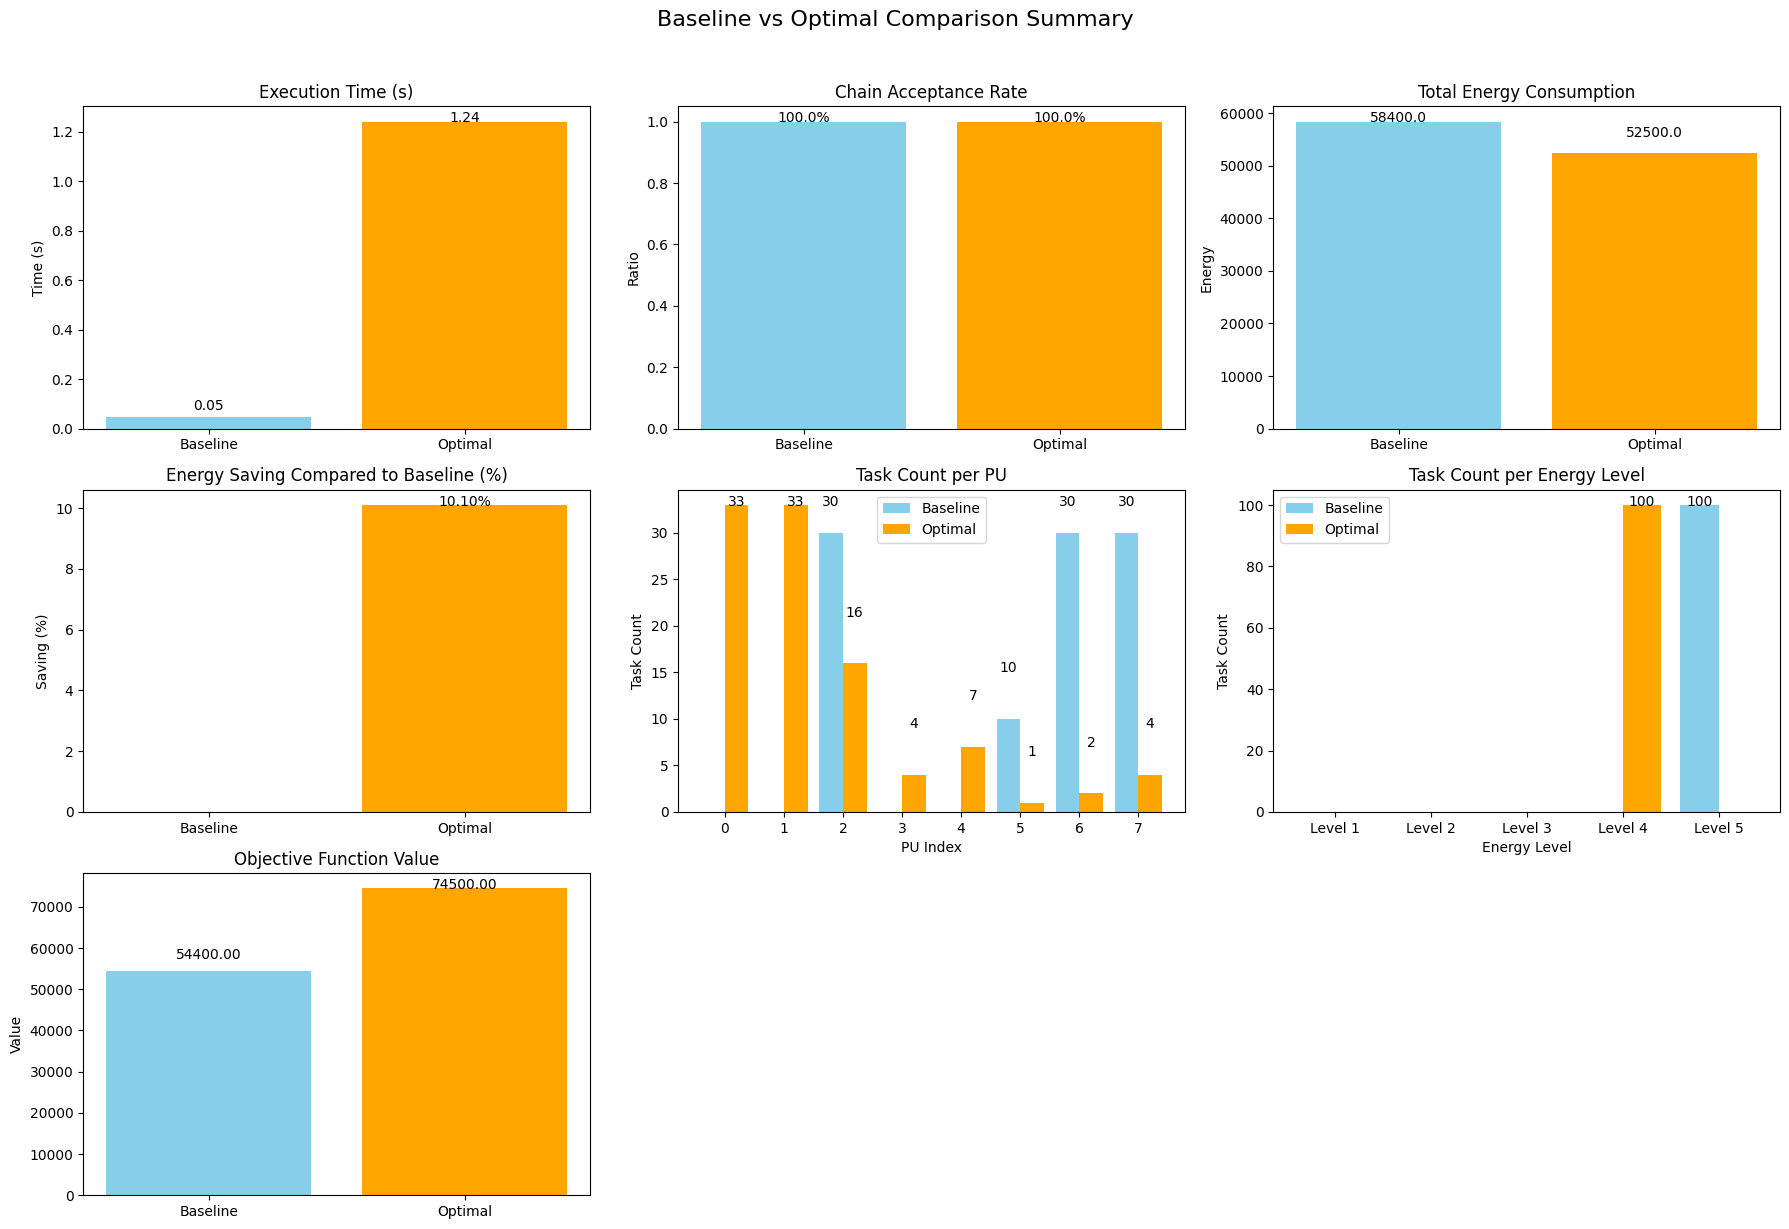

In [ ]:
baseline_result = run_gurobi_model(alpha_1=8000, alpha_2=3, alpha_3=1.5, baseline=True)
optimal_result  = run_gurobi_model(alpha_1=8000, alpha_2=3, alpha_3=1.5, baseline=False)
visualize_baseline_vs_optimal_extended(baseline_result, optimal_result)
